# The Development of Python HDBSCAN Compared to the Reference Implementation in Java

### Or, why I still use Python for high performance scientific computing

Python is a great high level language for easily expressing ideas, but people don't tend to think of it as a high performance language; for that you would want a compiled language -- ideally C or C++ but Java would do. This notebook started out as a simple benchmarking of the hdbscan clustering library written in Python against the reference implementation written in Java. It still does that, but it has expanded into an explanation of why I choose to use Python for performance critical scientific computing code.

## Some quick background

In 2013 Campello, Moulavi and Sander published a paper on a new clustering algorithm that they called HDBSCAN. In mid-2014 I was doing some general research on the current state of clustering, particularly with regard to exploratory data analysis. At the time DBSCAN or OPTICS appeared to be the most promising algorithm available. A colleague ran across the HDBSCAN paper in her literature survey, and suggested we look into how well it performed. We spent an afternoon learning the algorithm and coding it up and found that it gave remarkably good results for the range of test data we had. Things stayed in that state for some time, with the intention being to use a good HDBSCAN implementation when one became available. By early 2015 our needs for clustering grew and, having no good implementation of HDBSCAN to hand, I set about writing our own. Since the first version, coded up in an afternoon, had been in python I stuck with that choice -- but obviously performance might be an issue. In July 2015, after our implementation was well underway Campello, Moulavi and Sander published a new HDBSCAN paper, and released Java code to peform HDBSCAN clustering. Since one of our goals had been to get good scaling it became necessary to see how our python version compared to the high performance reference implementation in Java. 

This is the story of how our codebase evolved and was optimized, and how it compares with the Java version at different stages of that journey.

To make the comparisons we'll need data on runtimes of both algorithms, ranging over dataset size, and dataset dimension. To save time and space I've done that work in [another notebook](http://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Performance%20data%20generation%20.ipynb) and will just load the data in here.

In [1]:
import pandas as pd
import numpy as np

In [2]:
reference_timing_series = pd.read_csv('reference_impl_external_timings.csv', 
                                      index_col=(0,1), names=('dim', 'size', 'time'))['time']
hdbscan_v01_timing_series = pd.read_csv('hdbscan01_timings.csv', 
                                        index_col=(0,1), names=('dim', 'size', 'time'))['time']
hdbscan_v03_timing_series = pd.read_csv('hdbscan03_timings.csv', 
                                        index_col=(0,1), names=('dim', 'size', 'time'))['time']
hdbscan_v04_timing_series = pd.read_csv('hdbscan04_timings.csv', 
                                        index_col=(0,1), names=('dim', 'size', 'time'))['time']
hdbscan_v05_timing_series = pd.read_csv('hdbscan05_timings.csv', 
                                        index_col=(0,1), names=('dim', 'size', 'time'))['time']
hdbscan_v06_timing_series = pd.read_csv('hdbscan06_timings.csv', 
                                        index_col=(0,1), names=('dim', 'size', 'time'))['time']

## Why I chose Python: Easy development

The very first implementation of HDBSCAN that we did was coded up in an afternoon, and that code was in python. Why? There were a few reasons; the test data for clustering was already loaded in a notebook (we were using sklearn for testing many of the different clustering algorithms available); the notebook interface itself was very useful for the sort of iterative "what did we get at the end of this step" coding that occurs when you are both learning and coding a new algorithm at the same time; most of all though, python made the development *easy*. As a high level language, python simply made development that much easier by getting out of the way -- instead of battling with the language we could focus on battling with our understanding of the algorithm.

Easy development comes at a cost of course. That initial experimental implementation was terribly slow, taking thirty seconds or more to cluster only a few thousand points. That was to be expected to some extent: we were still learning and understanding the algorithm, and hence implemented things in a very literal and naive way. The benefit was in being able to get a working implementation put together well enough to test of real data and see the results -- because it was the remarkable promise of those results that made us pick HDBSCAN as the ideal clustering algorithm for exploratory data analysis.

## Why I chose Python: Great libraries

When push came to shove and it was decided that we needed to just write and implementation of HDBSCAN, I stuck with python. This was done despite the fact that the initial naive implementation was essentially abandoned, and a fresh start made. What motivated the decision this time? The many great libraries available for python. For a start there is [numpy](http://www.numpy.org) which provides access to highly optimized numerical array operations -- if you can phrase things in vectorized `numpy` operations then things will run fast, and the library is sufficiently flexible and expressive that it is usually not hard to phrase your problem that way. Next there is [scipy](http://www.scipy.org) and the excellent [sklearn](http://scikit-learn.org/stable/) libraries. By inhertiting from the `sklearn` estimator and cluster base classes (and making use of associated sklearn functions) the initial implementation supported input validation and conversion for a wide variety of input formats, a huge range of distance functions, and a standardised calling API all for practically free. In the early development stages I also benefitted from the power of libraries like [pandas](http://pandas.pydata.org) and [networkx](https://networkx.github.io) which provided easy and efficient access to database-like functionality and graphs and graph analytics.

When you combine that with easy checking and comparison with the naive implementation within the original clustering evaluation notebooks it just made a great deal of sense. With powerful and optimized libraries like `numpy` and `sklearn` doing the heavy lifting and a less naive implementation, hopefully performance wouldn't suffer too much...

We can compare that initial implementation with the reference implementation. First we need to load some plotting libraries so we can visualize the results.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('poster')
%matplotlib inline

Next we'll join together the reference timings with v0.1 hdbscan library timings, keeping track of which implementation is which, so that we can fit tidily into the `seaborn` library's `lmplot` routine.

In [4]:
reference_series = pd.DataFrame(reference_timing_series.copy()).reset_index()
reference_series['implementation'] = 'Reference Implemetation'

hdbscan_series = pd.DataFrame(hdbscan_v01_timing_series.copy()).reset_index()
hdbscan_series['implementation'] = 'hdbscan library'
hdbscan_series.columns = ('dim', 'size', 'time', 'implementation')

combined_data = pd.concat([reference_series, hdbscan_series])
combined_data['log(time)'] = np.log10(combined_data.time)
combined_data['log(size)'] = np.log10(combined_data['size'])

And now we plot the results. First we plot the raw timings ranging over increasing dataset sizes, using a different plot for datasets of different dimensions. Below that we have the log/log plots of the same.

(Double click on plots to make them larger)

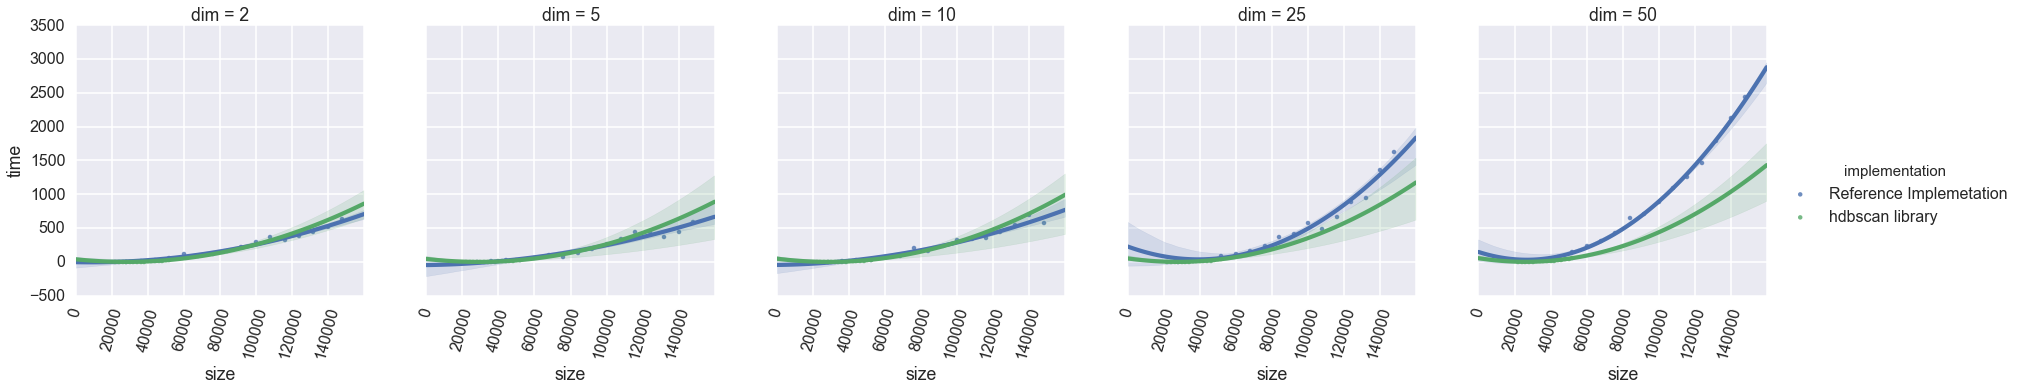

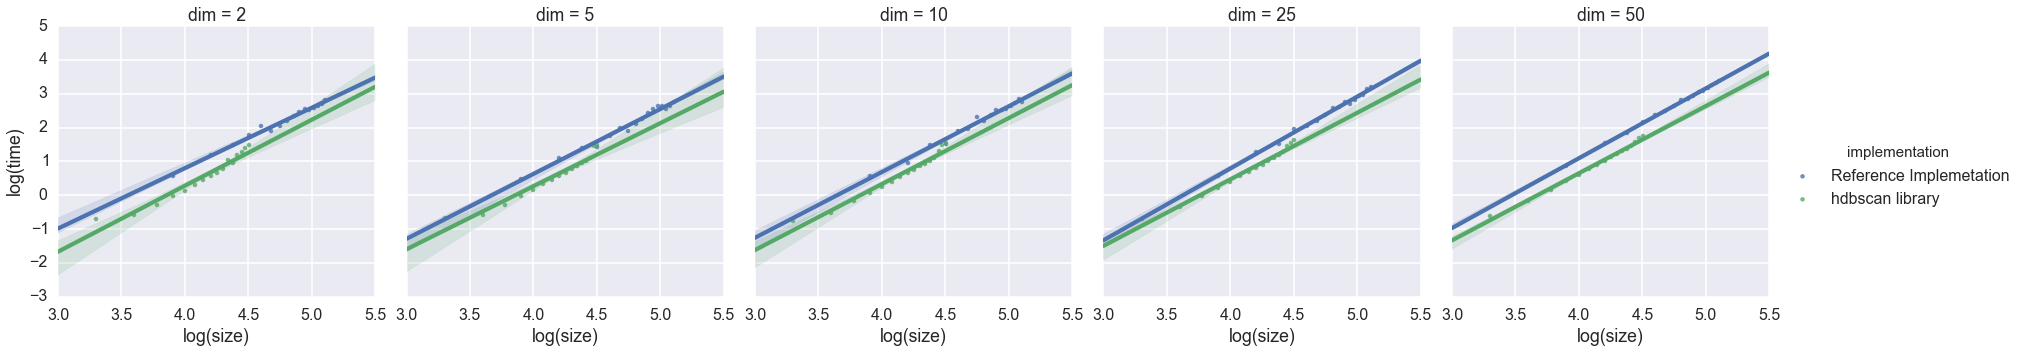

In [5]:
base_plot = sns.lmplot(x='size', y='time', hue='implementation', col='dim',
                       data=combined_data.reset_index(), order=2, size=5)
base_plot.set_xticklabels(np.arange(8)*20000, rotation=75)
log_plot = sns.lmplot(x='log(size)', y='log(time)', hue='implementation', col='dim', 
                      data=combined_data.reset_index(), size=5)

The result is perhaps a little surprising if you haven't worked with `numpy` that much: the python code doesn't scale as well the Java code, but it is not all that far off -- in fact when working with 25 or 50 dimensional data it is actually faster!

## Why I chose Python: Cython for bottlenecks

At this point in development I was still unaware of the reference implementation, and was comapring performance with other clustering algorithms such as single linkage, DBSCAN, and K-Means. From that point of view the hdbscan library still performed very poorly, and certainly didn't scale out to the size of datasets I potentially wanted to cluster. That meant it was time to roll up my sleeves and see if I could wring some further optimizations out. This is where the next win for python came: the easy gradient toward C. While `numpy` provided easy python access to fast routines written in C, not everything sat entirely within `numpy`. On the other hand [Cython](http://cython.org) provided an easy way to take my existing working python implementation and simply decorate it with C type information to allow the Cython compiler to generate efficient C code from my python. This allowed me get fast performance without having to rewrite anything -- I could modify the existing python code and be sure everything was still working (by running in the now familiar cluster testing notebooks). Better still, I only needed to spend effort on those parts of the code that were significant bottlenecks, everything else could simply remain as it was (the Cython compiler will happily work with pure undecorated python code).

I should point out that I could equally well have done similar things using [Numba](http://numba.pydata.org), but I had more familiarity with Cython at the time and it fit in better with `sklearn` practice and dependencies.

So, how did performance look at around this point? Let's have a look...

In [6]:
reference_series = pd.DataFrame(reference_timing_series.copy()).reset_index()
reference_series['implementation'] = 'Reference Implemetation'

hdbscan_series = pd.DataFrame(hdbscan_v03_timing_series.copy()).reset_index()
hdbscan_series['implementation'] = 'hdbscan library'
hdbscan_series.columns = ('dim', 'size', 'time', 'implementation')

combined_data = pd.concat([reference_series, hdbscan_series])
combined_data['log(time)'] = np.log10(combined_data.time)
combined_data['log(size)'] = np.log10(combined_data['size'])

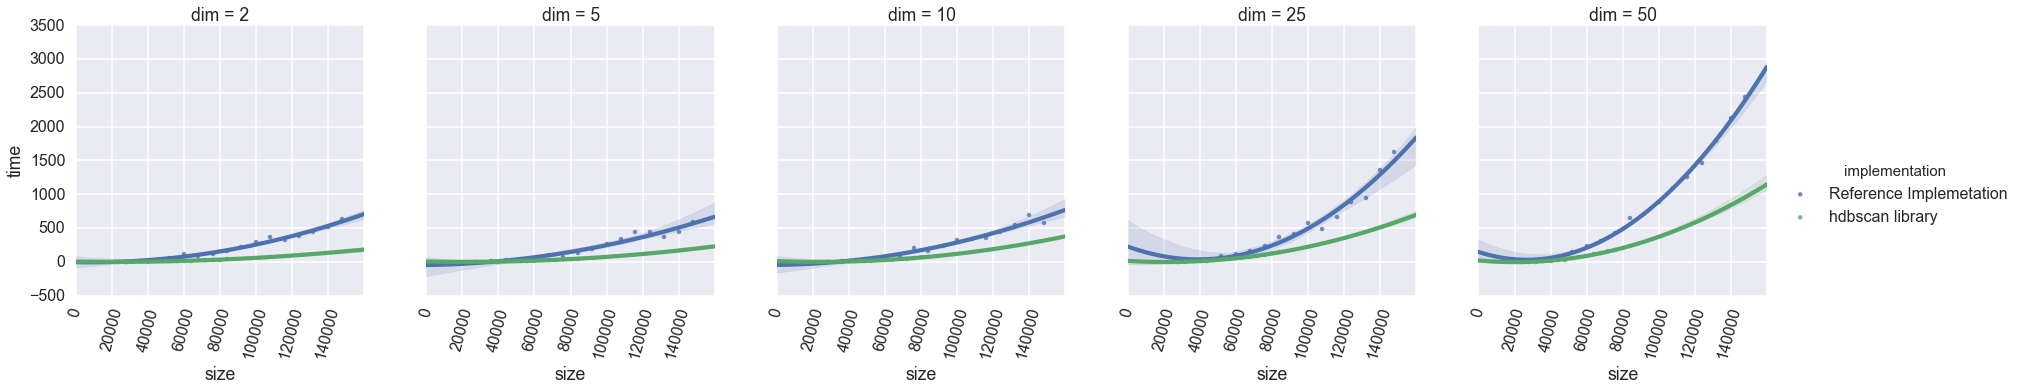

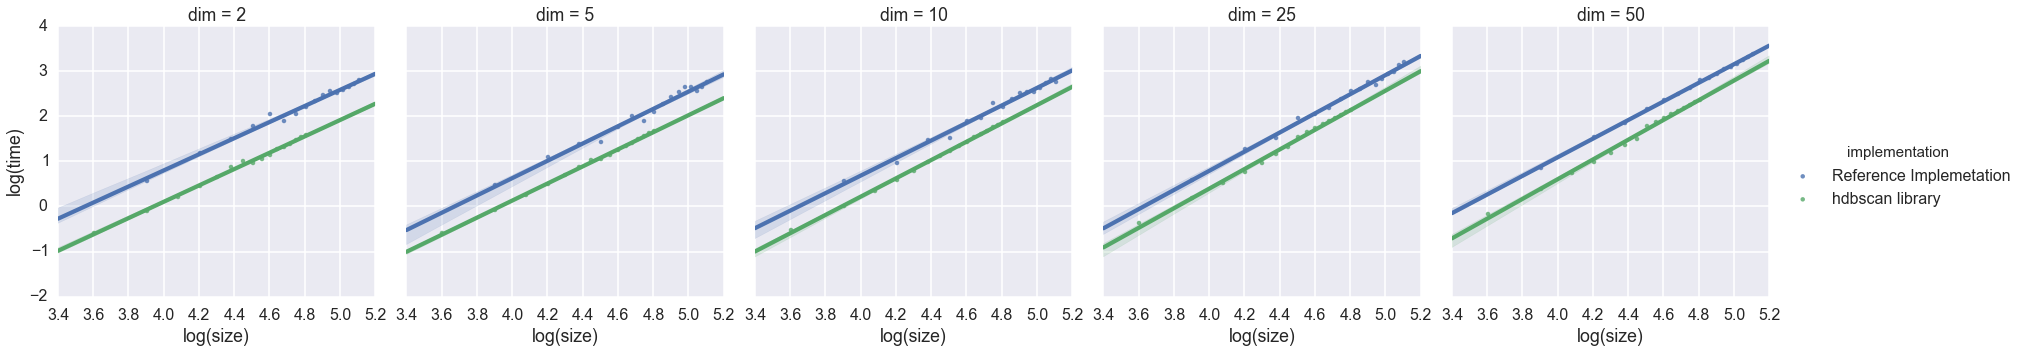

In [7]:
base_plot = sns.lmplot(x='size', y='time', hue='implementation', col='dim',
                       data=combined_data.reset_index(), order=2, size=5)
base_plot.set_xticklabels(np.arange(8)*20000, rotation=75)
log_plot = sns.lmplot(x='log(size)', y='log(time)', hue='implementation', col='dim', 
                      data=combined_data.reset_index(), size=5)

With a little optimization via Cython, the 0.3 version of hdbscan was now outperforming the reference implementation in Java! In fact in dimension 2 the hdbscan library is getting close to being an order of magnitude faster. It would seem that python isn't such a poor choice for performant code after all ...

## Why I chose Python: Because ultimately algorithms matter more

While I had been busy optimizing code, I had also been doing research on the side. The core of the HDBSCAN algorithm relied on a modified single linkage algorithm, which in turn relied on something akin to a minimum spanning tree algorithm. The optimal algorithm for that, according to the literature, is Prims algorithm. The catch is that this is an optimal choice for graphs where the number of edges is usually some (small) constant multiple of the number of vertices. The graph problem for HDBSCAN is a weighted complete graph with $N^2$ edges! That means that in practice we are stuck with an $O(N^2)$ algorithm. Other people, however, had been looking at what can be done when dealing with minimum spanning trees in the pathological case of complete graphs, and as long as you can embed your points into a metric space it turns out that there are other options. A paper by March, Ram and Gray described an algorithm using kd-trees that had $O(N \log N)$ complexity for small dimensional data. 

Faced with the difference between $O(N^2)$ and $O(N\log N)$ for large $N$ the choice of development language becomes much less significant -- what matters more is getting that $O(N\log N)$ algorithm implemented. Fortunately python made that easy. As in the case of the first naive versions of HDBSCAN, the notebook provided an excellent interface for exploratory interactive development while learning the algorithm. As in step two, great libraries made a difference: `sklearn` comes equipped with high performance implementations of kd-trees and ball trees that I could simpy make use of. Finally, as in step three, once I had a decent algorithm, I could turn to Cython to tighten up the bottlenecks and make it fast.

What sort of performance did we achieve with new algorithms?

In [8]:
reference_series = pd.DataFrame(reference_timing_series.copy()).reset_index()
reference_series['implementation'] = 'Reference Implemetation'

hdbscan_series = pd.DataFrame(hdbscan_v04_timing_series.copy()).reset_index()
hdbscan_series['implementation'] = 'hdbscan library'
hdbscan_series.columns = ('dim', 'size', 'time', 'implementation')

combined_data = pd.concat([reference_series, hdbscan_series])
combined_data['log(time)'] = np.log10(combined_data.time)
combined_data['log(size)'] = np.log10(combined_data['size'])

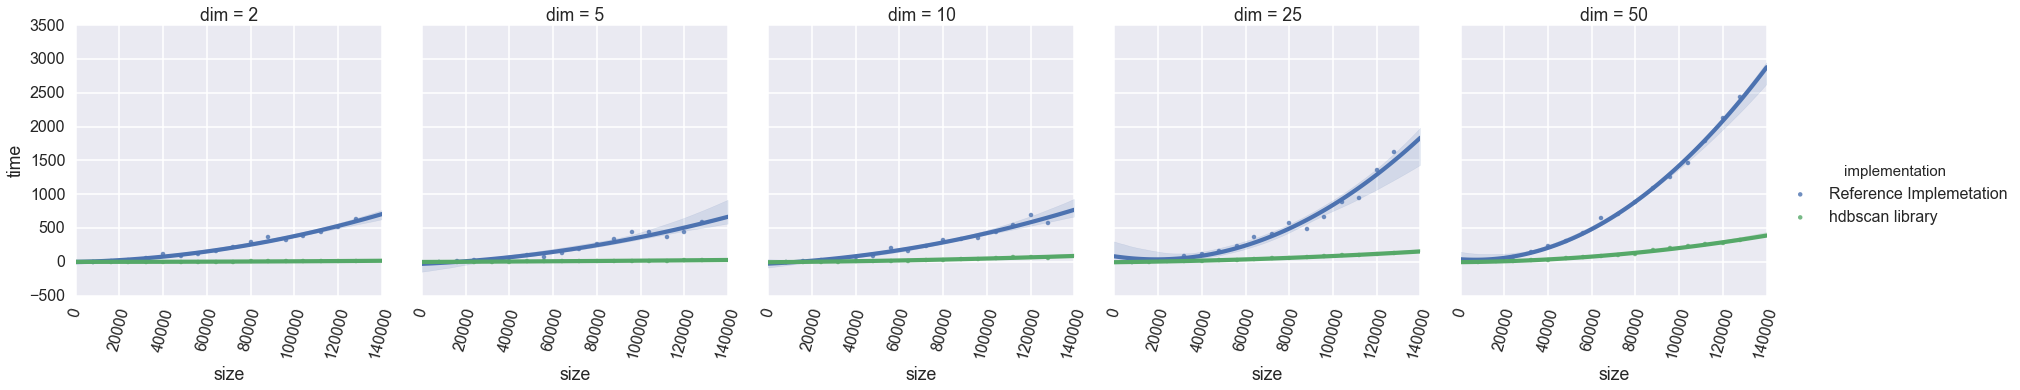

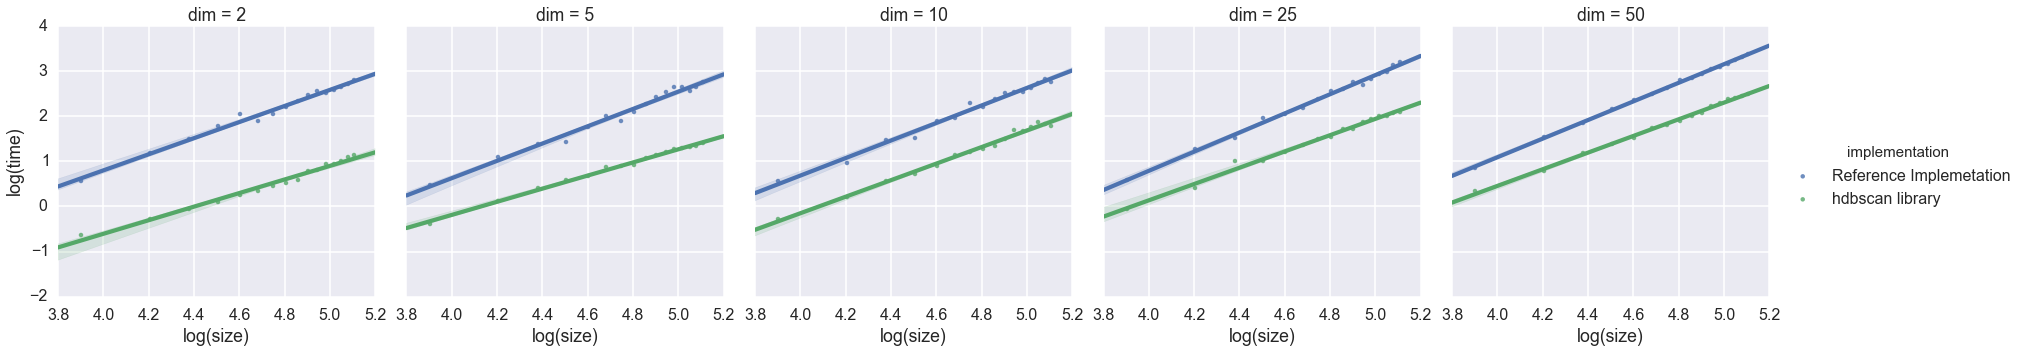

In [9]:
base_plot = sns.lmplot(x='size', y='time', hue='implementation', col='dim',
                       data=combined_data.reset_index(), order=2, size=5)
base_plot.set_xticklabels(np.arange(8)*20000, rotation=75)
log_plot = sns.lmplot(x='log(size)', y='log(time)', hue='implementation', col='dim', 
                      data=combined_data.reset_index(), size=5)

Now we are really starting to really separate out from the reference implementation. Only in the higher dimensional cases can you even see separation between the hdbscan library line and the x-axis. In the log/log plots we can see the difference really show, especially in low dimensions. The $O(N\log N)$ performance isn't showing up there though, so obviously we may still have some work to do.

## Why I chose Python: Because it makes optimization easy

The 0.4 release was a huge step forward in performance, but the $O(N\log N)$ scaling I was expecting to see (at least for low dimensions) wasn't apparent. Now the problem became tracking down where exactly time was being spent that perhaps it shouldn't be. Again python provided some nice benefits here. I was already doing my testing and benchmarking in the notebook (for the sake of plotting the benchmarks if nothing else). Merely adding `%prun` or `%lprun` to the top of cells got me profiling and even line level profiling information quickly and easily. From there it was easy to see that portions of code I had previously left written in very simple naive forms because they had negligible impact on performance were now, suddenly, a bottleneck. Going back to Cython, and particularly making use of [reports](http://docs.cython.org/src/quickstart/cythonize.html?highlight=html%20report#determining-where-to-add-types) produced by `cython -a` which provide excellent information about how your python code is being converted to C, it was not hard to speed up these routines. The result was the 0.5 release with performance below:

In [10]:
reference_series = pd.DataFrame(reference_timing_series.copy()).reset_index()
reference_series['implementation'] = 'Reference Implemetation'

hdbscan_series = pd.DataFrame(hdbscan_v05_timing_series.copy()).reset_index()
hdbscan_series['implementation'] = 'hdbscan library'
hdbscan_series.columns = ('dim', 'size', 'time', 'implementation')

combined_data = pd.concat([reference_series, hdbscan_series])
combined_data['log(time)'] = np.log10(combined_data.time)
combined_data['log(size)'] = np.log10(combined_data['size'])

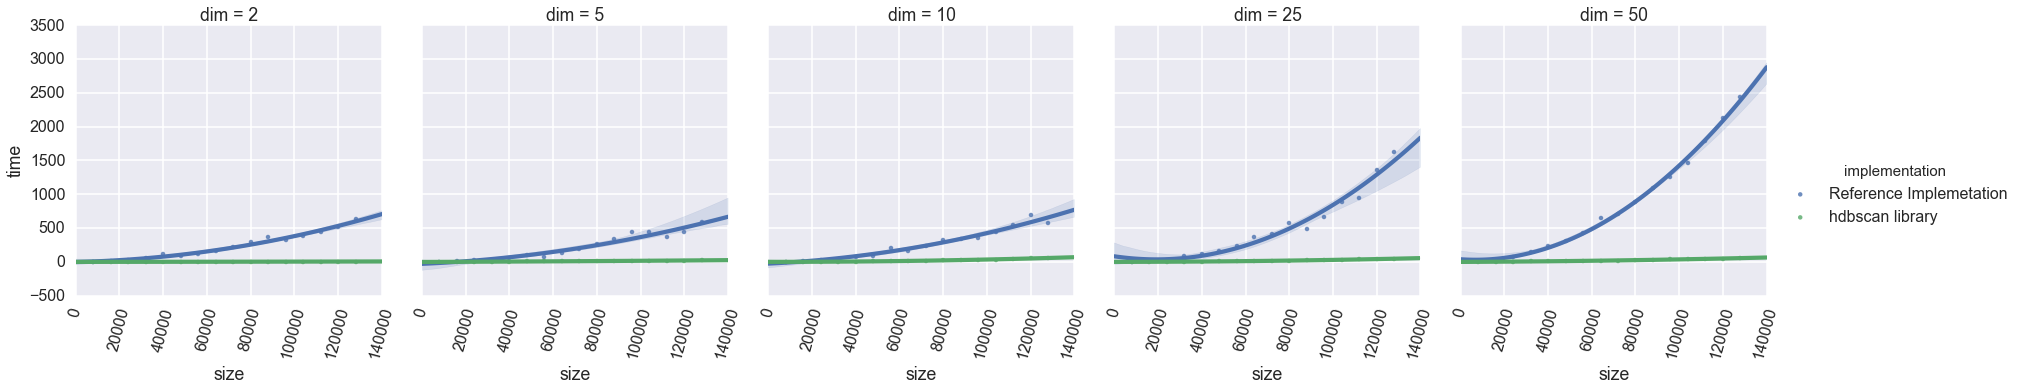

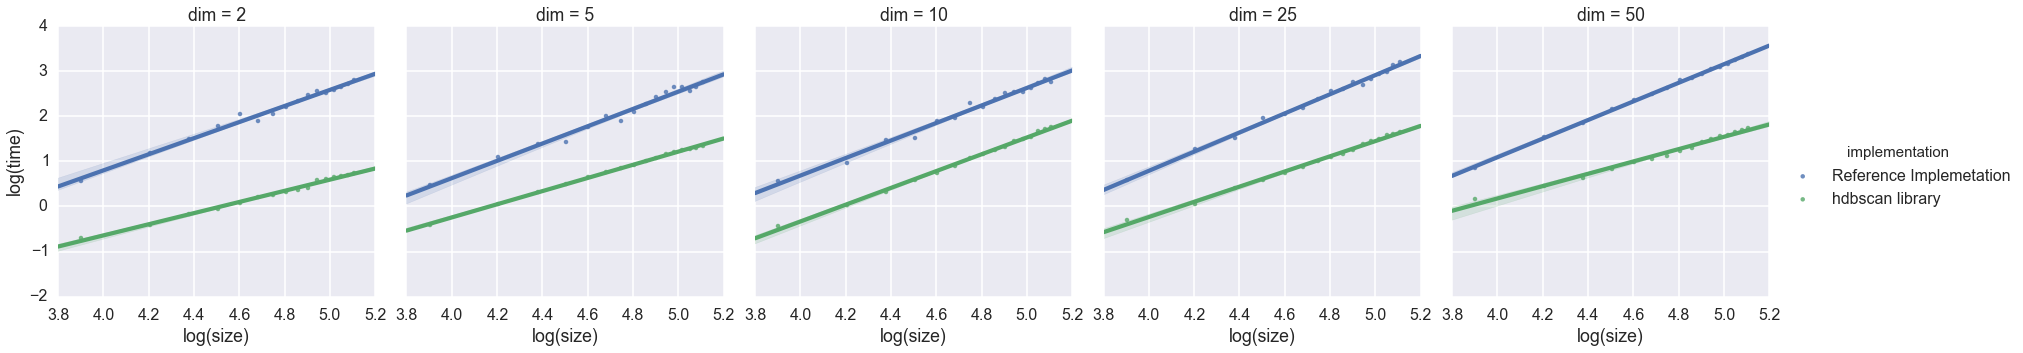

In [11]:
base_plot = sns.lmplot(x='size', y='time', hue='implementation', col='dim',
                       data=combined_data.reset_index(), order=2, size=5)
base_plot.set_xticklabels(np.arange(8)*20000, rotation=75)
log_plot = sns.lmplot(x='log(size)', y='log(time)', hue='implementation', col='dim', 
                      data=combined_data.reset_index(), size=5)

Now we can see a real difference in slopes in the log/log plot, with the implementation performance diverging in log scale for large dataset sizes (particularly in dimension 2). By the time we are dealing with datasets of size $10^5$ the python implementation is *two orders of magnitude faster* in dimension two! And that is only going to get better for the python implementation as we scale to larger and larger data sizes.

But there's still more -- there are still performance gains to be had for the python implementation, some to be delivered in the 0.6 release.

In [12]:
reference_series = pd.DataFrame(reference_timing_series.copy()).reset_index()
reference_series['implementation'] = 'Reference Implemetation'

hdbscan_series = pd.DataFrame(hdbscan_v06_timing_series.copy()).reset_index()
hdbscan_series['implementation'] = 'hdbscan library'
hdbscan_series.columns = ('dim', 'size', 'time', 'implementation')

combined_data = pd.concat([reference_series, hdbscan_series])
combined_data['log(time)'] = np.log10(combined_data.time)
combined_data['log(size)'] = np.log10(combined_data['size'])

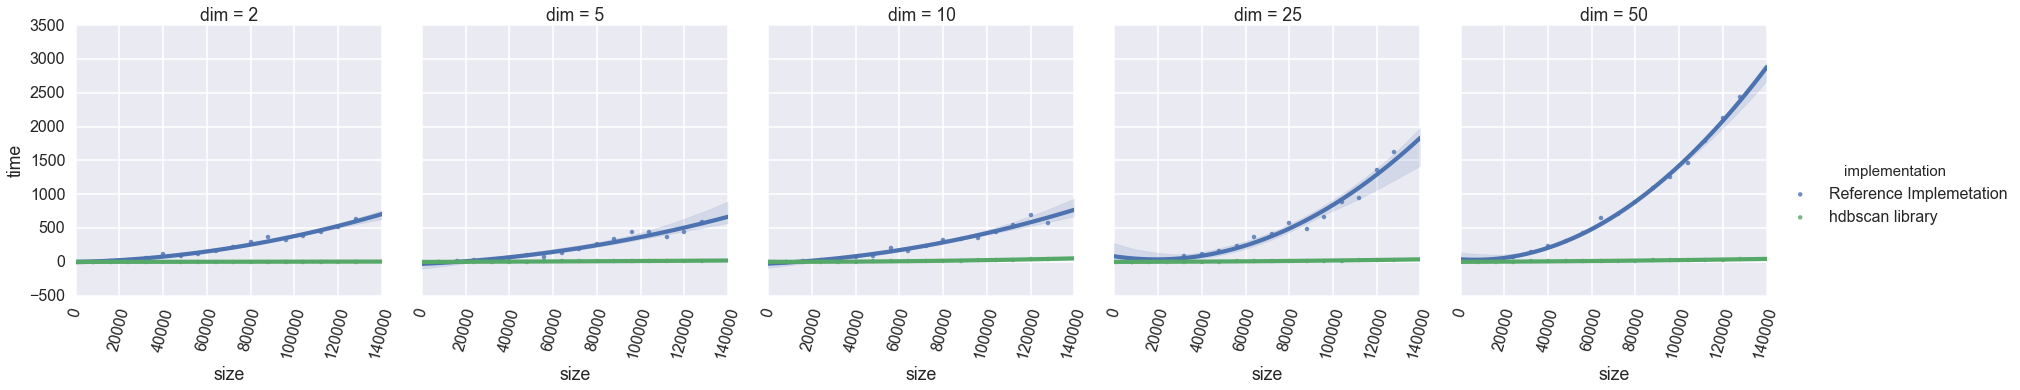

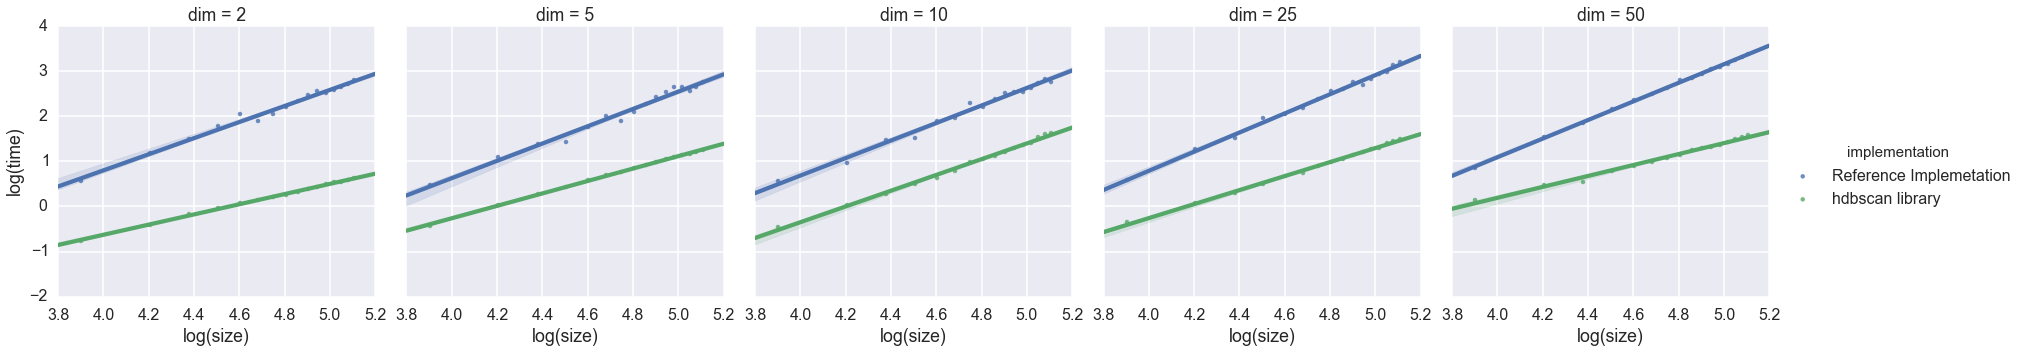

In [13]:
base_plot = sns.lmplot(x='size', y='time', hue='implementation', col='dim',
                       data=combined_data.reset_index(), order=2, size=5)
base_plot.set_xticklabels(np.arange(8)*20000, rotation=75)
log_plot = sns.lmplot(x='log(size)', y='log(time)', hue='implementation', col='dim', 
                      data=combined_data.reset_index(), size=5)

## Conclusions

So how did we fare developing a high performance clustering algorithm in python? Python certainly made the development process easy, not just in terms of initial code, but through great libraries, and by making optimization easy. The end result is an implementation several orders of magnitude faster than the current reference implementation in Java. So really, despite expectations, python didn't make things slow; quite the contrary. The lesson here is an old one from Knuth that I'm sure you already knew: *"premature optimization is root of all evil"*. Choosing a language "for performance" before you even know your algorithm well, and what parts of it will really be bottlenecks, is optimizing prematurely. Why not develop in a language that makes the first version easy to implement, and provides plenty of powerful tools for optimization later when you understand where and how you need it? And that's why I use python for high performance scientific computing.